In [17]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder
import graphviz
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

In [71]:
data_path=r'D:\study\Competition\porto-sequro-safe-driver-prediction\data'
train_df=pd.read_csv(data_path+'\\train.csv',na_values=-1)
test_df=pd.read_csv(data_path+'\\test.csv',na_values=-1)

In [72]:
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]
#所有calc变量
calc_features=[feat for feat in train_df.columns if 'calc' in feat]

In [73]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,4,2,7,7,0,1,1,0,1,0


### One_Hot_Encoding

### 每一个分类变量的缺失值我们用'最大值+1'来填充

In [75]:
oht_feat=pd.get_dummies(train_df[cat_features].append(test_df[cat_features]),columns=cat_features,dummy_na=True)

In [90]:
train_df=train_df.join(oht_feat.iloc[0:train_df.shape[0]])
test_df=test_df.join(oht_feat.iloc[train_df.shape[0]:])

### 方差为0（或取值唯一）的变量

In [99]:
useless_feats=list(train_df.columns[train_df.var()==0])

In [100]:
use_features=[x for x in train_df.columns if x not in ['id','target']+cat_features+useless_feats]

In [103]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [104]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=9)

# 1 Base line

In [116]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',gini(y, preds) / gini(y, y),True

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='auc',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    #print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    #print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0：.6f}'.format(gini_normalized_ordinary(y,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='split')
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [112]:
params={'boosting_type':'gbdt',
        'num_leaves':20,
        'max_depth':6,
        'learning_rate':0.2,
        'n_estimators':38,
        'max_bin':255,
        'objective':'binary',
        'min_split_gain':0,
        'min_child_weight':0,
        'min_child_samples':1,
        'subsample':1.0,
        'subsample_freq':1,
        'colsample_bytree':1.0,
        'reg_alpha':0,
        'reg_lambda':0,
        'random_state':9,
        'n_jobs':4,
        'is_unbalance':True,
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':20,
        'max_depth':6,
        'learning_rate':0.2,
        'max_bin':255,
        'objective':'binary',
        'min_gain_to_split':0,
        'min_sum_hessian_in_leaf':0,
        'min_data_in_leaf':1,
        'bagging_fraction':1.0,
        'bagging_freq':1,
        'feature_fraction':1.0,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':4,
        'is_unbalance':True,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [113]:
lgbc=lgb.LGBMClassifier(**params)

[20]	cv_agg's auc: 0.635203 + 0.00361775
[40]	cv_agg's auc: 0.633945 + 0.00335396
[60]	cv_agg's auc: 0.63193 + 0.00330429
Best Iteration: 23
Model report on trian:
Train AUC:0.6587
Model report on test:
Test AUC:0.6376
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.63      0.77    114704
          1       0.05      0.55      0.10      4339

avg / total       0.94      0.63      0.74    119043

Test confusion matrix:
Confusion matrix, without normalization
[[72535 42169]
 [ 1934  2405]]


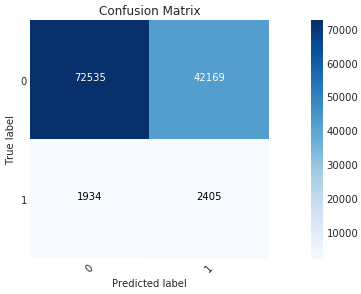

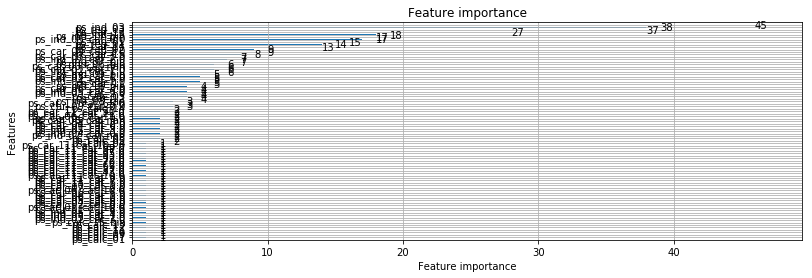

In [117]:
get_lgb_params(lgbc.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [83]:
#lgb.create_tree_digraph(lgbc)

In [118]:
params['n_estimators']=23

# 2 Tune params

In [122]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

## 2.1 subsample

In [123]:
searchParam={'subsample':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 1.0
Best score: 0.635892397832
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1         0.606563          0.634691        0.005348         0.001881
0.3         0.624748          0.654869        0.003623         0.001424
0.5         0.632122          0.660439        0.004758         0.001922
0.7         0.633977          0.662074        0.004527         0.001256
0.9         0.635200          0.662834        0.005273         0.001412
1.0         0.635892          0.663272        0.004313         0.001248


In [130]:
searchParam={'subsample':[0.95,0.96,0.97,0.98,0.99,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 0.95
Best score: 0.63698188483
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.95         0.636982          0.663309        0.005366         0.001165
0.96         0.635474          0.662750        0.003879         0.001359
0.97         0.635954          0.663300        0.005221         0.001565
0.98         0.635872          0.663607        0.005381         0.001458
0.99         0.635951          0.663045        0.004730         0.001351
1.00         0.635892          0.663272        0.004313         0.001248


## 2.3 colsample_bytree

In [135]:
searchParam={'colsample_bytree':[0.95,0.97,0.99,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 1.0
Best score: 0.63698188483
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.95         0.635607          0.663237        0.005630         0.000915
0.97         0.635857          0.663266        0.004562         0.001799
0.99         0.635601          0.663205        0.004669         0.001578
1.00         0.636982          0.663309        0.005366         0.001165


## 2.4 reg_alpha

In [138]:
searchParam={'reg_alpha':[20,21,25,27,30,35]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 35
Best score: 0.636916995544
    mean_test_score  mean_train_score  std_test_score  std_train_score
20         0.636112          0.662284        0.005305         0.000969
21         0.636132          0.661935        0.005428         0.001118
25         0.635826          0.661219        0.005223         0.001599
27         0.635807          0.661476        0.005344         0.001056
30         0.636327          0.661408        0.005301         0.000902
35         0.636917          0.661071        0.005308         0.001150


In [139]:
searchParam={'reg_alpha':[34,35,37,40,45,50]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 37
Best score: 0.63734944985
    mean_test_score  mean_train_score  std_test_score  std_train_score
34         0.636516          0.660784        0.005821         0.001230
35         0.636917          0.661071        0.005308         0.001150
37         0.637349          0.660813        0.005070         0.000805
40         0.636145          0.660842        0.006272         0.001236
45         0.635848          0.660618        0.004697         0.001273
50         0.636690          0.660303        0.005013         0.001457


In [141]:
searchParam={'reg_alpha':[36.6,36.8,36.9,37,37.1,37.2,37.4]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 37.2
Best score: 0.637349692228
      mean_test_score  mean_train_score  std_test_score  std_train_score
36.6         0.637317          0.660844        0.005118         0.000822
36.8         0.637215          0.660900        0.005158         0.000874
36.9         0.637349          0.660815        0.005070         0.000806
37.0         0.637349          0.660813        0.005070         0.000805
37.1         0.637350          0.660810        0.005070         0.000805
37.2         0.637350          0.660807        0.005069         0.000805
37.4         0.637332          0.660843        0.005069         0.000842


## 2.5 reg_lambda

In [142]:
searchParam={'reg_lambda':[0,1e-5,1e-3,0.1,0.5,1]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.001
Best score: 0.637349699135
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.637350          0.660807        0.005069         0.000805
0.00001         0.637350          0.660807        0.005069         0.000805
0.00100         0.637350          0.660807        0.005069         0.000805
0.10000         0.637347          0.660848        0.005072         0.000841
0.50000         0.637263          0.660838        0.004939         0.000849
1.00000         0.637182          0.660697        0.004788         0.001099


In [143]:
searchParam={'reg_lambda':[1e-4,5e-4,1e-3,2e-3,5e-3,0.01]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 0.002
Best score: 0.637349706043
        mean_test_score  mean_train_score  std_test_score  std_train_score
0.0001         0.637350          0.660807        0.005069         0.000805
0.0005         0.637350          0.660807        0.005069         0.000805
0.0010         0.637350          0.660807        0.005069         0.000805
0.0020         0.637350          0.660807        0.005069         0.000805
0.0050         0.637347          0.660849        0.005072         0.000841
0.0100         0.637347          0.660849        0.005072         0.000841


## 2.6 min_child_samples

In [144]:
searchParam={'min_child_samples':[1,2,3,4,5,6,7]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_samples : 1
Best score: 0.637349706043
   mean_test_score  mean_train_score  std_test_score  std_train_score
1          0.63735          0.660807        0.005069         0.000805
2          0.63735          0.660807        0.005069         0.000805
3          0.63735          0.660807        0.005069         0.000805
4          0.63735          0.660807        0.005069         0.000805
5          0.63735          0.660807        0.005069         0.000805
6          0.63735          0.660807        0.005069         0.000805
7          0.63735          0.660807        0.005069         0.000805


## 2.7 min_child_weight

In [147]:
searchParam={'min_child_weight':[0,1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 0
Best score: 0.637349706043
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000          0.63735          0.660807        0.005069         0.000805
0.00001          0.63735          0.660807        0.005069         0.000805
0.00100          0.63735          0.660807        0.005069         0.000805
0.10000          0.63735          0.660807        0.005069         0.000805
0.50000          0.63735          0.660807        0.005069         0.000805
1.00000          0.63735          0.660807        0.005069         0.000805
3.00000          0.63735          0.660807        0.005069         0.000805
5.00000          0.63735          0.660807        0.005069         0.000805


## 2.9 min_split_gain

In [148]:
searchParam={'min_split_gain':[0,0.5,0.9,1,1.1,2,3]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 0
Best score: 0.637349706043
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.0         0.637350          0.660807        0.005069         0.000805
0.5         0.637148          0.660621        0.005032         0.001164
0.9         0.637085          0.660673        0.005033         0.001191
1.0         0.637282          0.660702        0.004971         0.001216
1.1         0.637288          0.660653        0.004971         0.001246
2.0         0.636502          0.660578        0.004896         0.001162
3.0         0.636710          0.660608        0.004722         0.001079


## 2.10 num_leaves

In [150]:
searchParam={'num_leaves':[3,5,7]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 7
Best score: 0.633042879386
   mean_test_score  mean_train_score  std_test_score  std_train_score
3         0.625724          0.629608        0.004505         0.001288
5         0.630622          0.637408        0.004846         0.001613
7         0.633043          0.642017        0.004158         0.000890


In [151]:
searchParam={'num_leaves':[7,9,11,15]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 11
Best score: 0.635762077866
    mean_test_score  mean_train_score  std_test_score  std_train_score
7          0.633043          0.642017        0.004158         0.000890
9          0.634044          0.645414        0.005875         0.000936
11         0.635762          0.648973        0.005178         0.001287
15         0.635285          0.654847        0.005204         0.001226


In [152]:
searchParam={'num_leaves':[10,11,12,13,14]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 14
Best score: 0.636184500827
    mean_test_score  mean_train_score  std_test_score  std_train_score
10         0.635278          0.647274        0.005076         0.001179
11         0.635762          0.648973        0.005178         0.001287
12         0.636044          0.650576        0.004682         0.001571
13         0.636176          0.651962        0.004628         0.000949
14         0.636185          0.653273        0.004509         0.001427


In [153]:
searchParam={'num_leaves':[14,15,16,20]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 20
Best score: 0.637349706043
    mean_test_score  mean_train_score  std_test_score  std_train_score
14         0.636185          0.653273        0.004509         0.001427
15         0.635285          0.654847        0.005204         0.001226
16         0.636113          0.656082        0.004543         0.001369
20         0.637350          0.660807        0.005069         0.000805


In [154]:
searchParam={'num_leaves':[18,19,20,21,25,30]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 20
Best score: 0.637349706043
    mean_test_score  mean_train_score  std_test_score  std_train_score
18         0.636257          0.658266        0.004818         0.000750
19         0.636619          0.659898        0.004754         0.001196
20         0.637350          0.660807        0.005069         0.000805
21         0.635591          0.662024        0.005021         0.001161
25         0.634249          0.666300        0.005271         0.001309
30         0.635766          0.671904        0.004799         0.001879


## 2.10 max_depth

In [156]:
searchParam={'max_depth':[6,7,8,9]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 6
Best score: 0.637349706043
   mean_test_score  mean_train_score  std_test_score  std_train_score
6         0.637350          0.660807        0.005069         0.000805
7         0.637233          0.661268        0.004477         0.001206
8         0.637021          0.661839        0.005636         0.001211
9         0.636337          0.662108        0.005603         0.001230


## 2.11 lower learning_rate

[20]	cv_agg's auc: 0.615388 + 0.00263045
[40]	cv_agg's auc: 0.619187 + 0.00294828
[60]	cv_agg's auc: 0.622387 + 0.0033581
[80]	cv_agg's auc: 0.625038 + 0.003733
[100]	cv_agg's auc: 0.626947 + 0.0040943
[120]	cv_agg's auc: 0.62862 + 0.00437775
[140]	cv_agg's auc: 0.63006 + 0.00437322
[160]	cv_agg's auc: 0.631128 + 0.00445017
[180]	cv_agg's auc: 0.632279 + 0.00440863
[200]	cv_agg's auc: 0.633253 + 0.0044185
[220]	cv_agg's auc: 0.634077 + 0.00449291
[240]	cv_agg's auc: 0.634864 + 0.00452748
[260]	cv_agg's auc: 0.635518 + 0.00457832
[280]	cv_agg's auc: 0.636131 + 0.00464786
[300]	cv_agg's auc: 0.636685 + 0.00466929
[320]	cv_agg's auc: 0.637133 + 0.00466265
[340]	cv_agg's auc: 0.637607 + 0.0046169
[360]	cv_agg's auc: 0.637939 + 0.0045913
[380]	cv_agg's auc: 0.638259 + 0.00460722
[400]	cv_agg's auc: 0.638523 + 0.00457008
[420]	cv_agg's auc: 0.638737 + 0.00457217
[440]	cv_agg's auc: 0.638964 + 0.00447435
[460]	cv_agg's auc: 0.639187 + 0.00444211
[480]	cv_agg's auc: 0.639354 + 0.00441663
[500]

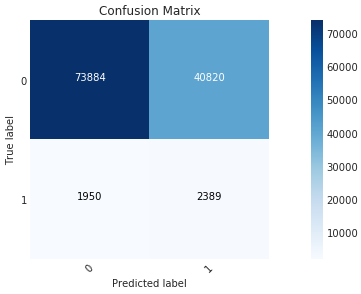

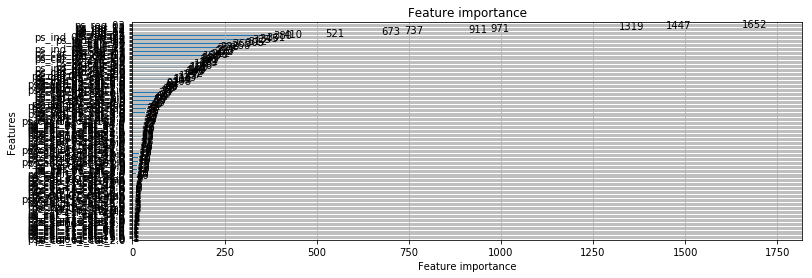

In [158]:
params['learning_rate']=0.01
lgbc=lgb.LGBMClassifier(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

[20]	cv_agg's auc: 0.626511 + 0.00396501
[40]	cv_agg's auc: 0.632883 + 0.00452943
[60]	cv_agg's auc: 0.636243 + 0.00475028
[80]	cv_agg's auc: 0.638259 + 0.00471581
[100]	cv_agg's auc: 0.639147 + 0.00440668
[120]	cv_agg's auc: 0.639907 + 0.00440301
[140]	cv_agg's auc: 0.64018 + 0.00423821
[160]	cv_agg's auc: 0.640356 + 0.00419176
[180]	cv_agg's auc: 0.640267 + 0.00401833
[200]	cv_agg's auc: 0.640278 + 0.00403967
Best Iteration: 162
Model report on trian:
Train AUC:0.6725
Model report on test:
Test AUC:0.6413
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.64      0.77    114704
          1       0.06      0.55      0.10      4339

avg / total       0.94      0.64      0.75    119043

Test confusion matrix:
Confusion matrix, without normalization
[[73461 41243]
 [ 1935  2404]]


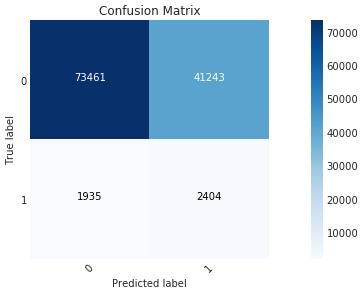

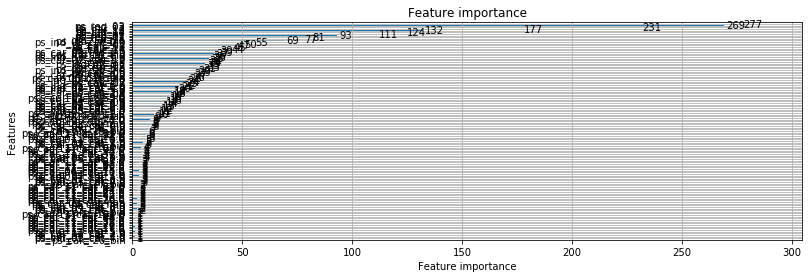

In [160]:
params['learning_rate']=0.05
lgbc=lgb.LGBMClassifier(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [161]:
params['n_estimators']=162

# 3 Final model

In [162]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 1.0,
 'is_unbalance': True,
 'learning_rate': 0.05,
 'max_bin': 255,
 'max_depth': 6,
 'min_child_samples': 1,
 'min_child_weight': 0,
 'min_split_gain': 0,
 'n_estimators': 162,
 'n_jobs': 4,
 'num_leaves': 20,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 37.2,
 'reg_lambda': 0.002,
 'subsample': 0.95,
 'subsample_freq': 1}

In [163]:
lgbc_opt=lgb.LGBMClassifier(**params)

### cv

In [164]:
searchParam={'max_depth':[6]}
turnParams(lgbc_opt,X,y,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 6
Best score: 0.640936671152
   mean_test_score  mean_train_score  std_test_score  std_train_score
6         0.640937           0.67268        0.002706         0.000369


In [165]:
lgbc_opt.fit(X,y,feature_name=list(X.columns),categorical_feature='auto')

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1.0, is_unbalance=True,
        learning_rate=0.05, max_bin=255, max_depth=6, min_child_samples=1,
        min_child_weight=0, min_split_gain=0, n_estimators=162, n_jobs=4,
        num_leaves=20, objective='binary', random_state=9, reg_alpha=37.2,
        reg_lambda=0.002, silent=True, subsample=0.95,
        subsample_for_bin=50000, subsample_freq=1)

In [166]:
joblib.dump(lgbc_opt,r'D:\study\Competition\kaggle-PSSDP-20171014\20171102_14LightGBM.pkl')

['D:\\study\\Competition\\kaggle-PSSDP-20171014\\20171102_14LightGBM.pkl']

In [167]:
pred_prob=lgbc_opt.predict_proba(X_predict)[:,1]

In [168]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [169]:
predict_result.head()

,id,target
0,0,0.416894
1,1,0.437842
2,2,0.422406
3,3,0.281879
4,4,0.494555


In [170]:
predict_result.to_csv(r'D:\study\Competition\kaggle-PSSDP-20171014\20171102_14lgbm.csv',index=False)

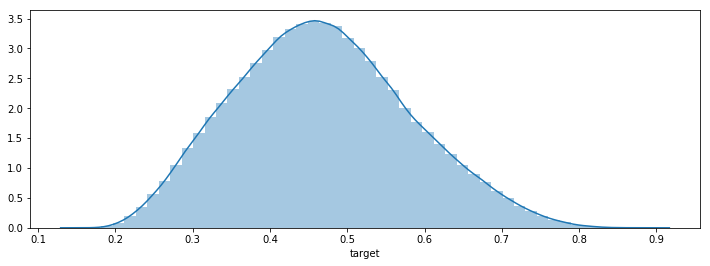

In [172]:
sns.distplot(predict_result['target'])

In [173]:
predict_result['target'].describe()

count    892816.000000
mean          0.467750
std           0.112784
min           0.152381
25%           0.386147
50%           0.463037
75%           0.543116
max           0.893551
Name: target, dtype: float64